In [78]:
% matplotlib notebook
import numpy as np
import pandas as pd
import skynet.nwp2d as npd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from IPython.core.interactiveshell import InteractiveShell
from IPython.display import display

InteractiveShell.ast_node_interactivity = 'all'


後で楽なように適当に処理をまとめておく

In [2]:
import re
import copy
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from skynet.mlcore.feature_selection.filter import pearson_correlation

ss = StandardScaler()


class LearningOperator(object):
    def __init__(self, model, X_train: pd.DataFrame, y_train, X_test: pd.DataFrame, y_test):
        self.__model = model
        self.__X_train = X_train
        self.__y_train = y_train
        self.__X_test = X_test
        self.__y_test = y_test

        self.__init_model = copy.deepcopy(model)
        self.__init_X_train = copy.deepcopy(X_train)
        self.__init_y_train = copy.deepcopy(y_train)
        self.__init_X_test = copy.deepcopy(X_test)
        self.__init_y_test = copy.deepcopy(y_test)

        self.X_train_norm = pd.DataFrame(
            ss.fit_transform(self.X_train.values),
            columns=self.X_train.keys()
        )

        self.X_test_norm = pd.DataFrame(
            ss.fit_transform(self.X_test.values),
            columns=self.X_test.keys()
        )

        self.y_pred_ = None
        self.accuracy_ = None
        self.f1_ = None

    @property
    def init_model(self):
        return self.__init_model

    @property
    def model(self):
        return self.__model

    @model.setter
    def model(self, model):
        self.__model = model

    @property
    def X_train(self):
        return self.__X_train

    @X_train.setter
    def X_train(self, X_train):
        self.__X_train = X_train

    @property
    def y_train(self):
        return self.__y_train

    @property
    def X_test(self):
        return self.__X_test

    @X_test.setter
    def X_test(self, X_test):
        self.__X_test = X_test

    @property
    def y_test(self):
        return self.__y_test

    @property
    def init_X_train(self):
        return self.__init_X_train

    @property
    def init_y_train(self):
        return self.__init_y_train

    @property
    def init_X_test(self):
        return self.__init_X_test

    @property
    def init_y_test(self):
        return self.__init_y_test

    def set_learning_data(self, X_train: pd.DataFrame, y_train, X_test: pd.DataFrame, y_test):
        self.__X_train = X_train
        self.__y_train = y_train
        self.__X_test = X_test
        self.__y_test = y_test

    def reset_model(self):
        self.model = self.__init_model

    def reset_learning_data(self):
        self.__X_train = self.init_X_train
        self.__y_train = self.init_y_train
        self.__X_test = self.init_X_test
        self.__y_test = self.init_y_test

        self.X_train_norm = pd.DataFrame(
            ss.fit_transform(self.__X_train.values),
            columns=X_train.keys()
        )

        self.X_test_norm = pd.DataFrame(
            ss.fit_transform(self.__X_test.values),
            columns=X_test.keys()
        )

    def test_model_performance(self, show_accuracy=True, show_f1=True, show_conf_mat=True):
        self.reset_model()
        self.model.fit(self.X_train, self.y_train)
        self.y_pred_ = self.model.predict(self.X_test)

        self.accuracy_ = accuracy_score(self.y_test, self.y_pred_)
        if show_accuracy:
            print('Test Accuracy: %0.2f' % self.accuracy_)

        self.f1_ = calc_f1(self.y_test, self.y_pred_)
        if show_f1:
            print('Test F value : %0.2f' % self.f1_)

        cfm = conf_mat(self.y_test, self.y_pred_, steps=[0, 1])

        if show_conf_mat:
            display(cfm)

    def convert_wind_dir(self):
        azi_train = pd.DataFrame()
        azi_test = pd.DataFrame()

        wd_train = vecwd_to_stepwd(
            self.__init_X_train['u-component of wind'],
            self.__init_X_train['v-component of wind'],
            norm=True
        )

        wd_test = vecwd_to_stepwd(
            self.__init_X_test['u-component of wind'],
            self.__init_X_test['v-component of wind'],
            norm=True
        )

        azi_train['wind direction'] = wd_train
        azi_test['wind direction'] = wd_test

        hpas = np.unique([key[4:] for key in self.__init_X_train.keys() if re.match('\D+\d+', key)])
        wd_keys = ['wndr%s' % hpa for hpa in hpas]

        for hpa, key in zip(hpas, wd_keys):
            wd_train = vecwd_to_stepwd(
                self.__init_X_train['u-co%s' % hpa],
                self.__init_X_train['v-co%s' % hpa],
                norm=True
            )
            wd_test = vecwd_to_stepwd(
                self.__init_X_test['u-co%s' % hpa],
                self.__init_X_test['v-co%s' % hpa],
                norm=True
            )
            azi_train[key] = wd_train
            azi_test[key] = wd_test

        u_co = [u for u in self.X_train.keys() if 'u-co' in u]
        v_co = [v for v in self.X_train.keys() if 'v-co' in v]

        self.X_train = self.X_train.drop(u_co, axis=1)
        self.X_train = self.X_train.drop(v_co, axis=1)
        self.X_test = self.X_test.drop(u_co, axis=1)
        self.X_test = self.X_test.drop(v_co, axis=1)

        wndr = [wd for wd in self.X_train.keys() if ('wndr' in wd) or ('wind direction' in wd)]
        if not len(wndr):
            self.X_train = pd.concat([self.X_train, azi_train], axis=1)
            self.X_test = pd.concat([self.X_test, azi_test], axis=1)

    def fwsearch(self, X_train, y_train, X_test, y_test, filter_method='corr'):
        acc = np.zeros(len(X_train.keys()) - 1)
        f1 = np.zeros(len(X_train.keys()) - 1)
        for n in range(1, len(X_train.keys())):
            if filter_method == 'corr':
                selected_fets = pearson_correlation(
                    X_train,
                    y_train,
                    depth=n
                )
            else:
                selected_fets = []

            self.set_learning_data(
                X_train[selected_fets],
                y_train,
                X_test[selected_fets],
                y_test
            )

            self.test_model_performance(show_accuracy=False, show_f1=False, show_conf_mat=False)
            acc[n - 1] = self.accuracy_
            f1[n - 1] = self.f1_

        return acc, f1

def conf_mat(y_true, y_pred, steps):
    import numpy as np

    rank = len(steps)
    delta = np.diff(np.array(steps + [1000000]).astype(int))

    t = np.zeros_like(y_true)
    p = np.zeros_like(y_pred)

    for i, d in enumerate(delta):
        t[(y_true >= steps[i]) & (y_true < (steps[i] + d))] = i
        p[(y_pred >= steps[i]) & (y_pred < (steps[i] + d))] = i

    cfm = np.zeros((rank, rank))
    for i in range(rank):
        for j in range(rank):
            cfm[i, j] = len(np.where((t == i) & (p == j))[0])

    cfm = pd.DataFrame(
        cfm.astype(int),
        index=['Actual +', 'Actual -'],
        columns=['Predicted +', 'Predicted -']
    )

    return cfm


def calc_f1(y_true, y_pred):
    import numpy as np
    from sklearn.metrics import f1_score

    y_true_bn = np.zeros_like(y_true)
    y_true_bn[y_true < 1] = 1

    y_pred_bn = np.zeros_like(y_pred)
    y_pred_bn[y_pred < 1] = 1

    f1 = f1_score(y_true_bn, y_pred_bn)

    return f1

def vecwd_to_stepwd(wu, wv, norm=False):
    theta = np.arctan(wv / wu)
    theta[(wu < 0) & (wv >= 0)] = theta[(wu < 0) & (wv >= 0)] + np.pi
    theta[(wu >= 0) & (wv < 0)] = theta[(wu >= 0) & (wv < 0)] + 2 * np.pi
    theta[(wu < 0) & (wv < 0)] = theta[(wu < 0) & (wv < 0)] + np.pi

    deg = np.rad2deg(theta)

    deg_range1 = np.arange(11.25, 337.5, 22.5)
    deg_range2 = np.arange(33.75, 360, 22.5)

    azi = np.zeros_like(theta)

    '''
    print(
        'azimuth number : 0\ndegree %.2f - %.2f and %.2f - %.2f \n'
        % (0, 11.25, 348.75, 360)
    )
    '''
    for i in range(1, len(deg_range1) + 1):
        th1 = deg_range1[i - 1]
        th2 = deg_range2[i - 1]
        # print('azimuth number : %d\ndegree %.2f - %.2f\n' % (i, th1, th2))
        azi[(deg >= th1) & (deg < th2)] = i

    if norm:
        azi = (azi - azi.min()) / (azi.max() - azi.min())

    return azi


In [3]:
from skynet import DATA_DIR

icao = 'RJCC'

data_dir = '%s/ARC-common/fit_input/JMA_MSM/vis' % DATA_DIR
model_dir = '%s/ARC-common/fit_output/JMA_MSM/vis' % DATA_DIR
data_name = 'GLOBAL_METAR-%s.vis.csv' % icao
model_name = 'GLOBAL_METAR-%s.vis.pkl' % icao


In [4]:
import skynet.datasets as skyds

train = skyds.read_csv('%s/%s' % (data_dir, data_name))


説明変数と目的変数を分離

In [5]:
fets = skyds.get_init_features()
target = skyds.get_init_target()

train = train[fets + target]

X_train = train.iloc[:, :-1]
y_train = train.iloc[:, -1]

print('X :')
display(X_train.tail())

print()
print('y :')
display(y_train.tail())

X :


,month,day,hour,Pressure reduced to MSL,Pressure,u-component of wind,v-component of wind,Temperature,Relative humidity,Low cloud cover,...,v-co400,Temp400,Vert400,Rela400,Geop300,u-co300,v-co300,Temp300,Vert300,Rela300
17490,12,31,19,102251.7578,101851.8677,-0.3193,0.4817,255.0951,84.4308,7.4219,...,-3.3410,231.8039,-0.1967,39.2687,8855.1833,23.3240,-2.7764,217.8159,0.1247,50.5935
17491,12,31,20,102244.5557,101840.0818,-0.4729,0.6044,255.1464,85.1554,7.1777,...,-3.4526,231.9906,-0.1295,33.7468,8853.0198,23.4555,-2.6925,217.7097,0.1662,52.5975
17492,12,31,21,102240.7593,101837.8113,-0.7237,0.8614,255.6707,86.2834,4.1504,...,-3.5642,232.1774,-0.0623,28.2249,8850.8564,23.5871,-2.6087,217.6035,0.2078,54.6015
17493,12,31,22,102241.2598,101836.9507,-0.8680,1.0521,256.2000,86.4506,4.9805,...,-2.4891,232.0829,-0.0485,39.1686,8849.0602,23.1244,-1.2225,217.5608,0.1922,52.3367
17494,12,31,23,102235.0708,101834.8572,-1.4124,0.9927,257.9706,85.3456,0.4395,...,-1.4140,231.9885,-0.0348,50.1124,8847.2640,22.6618,0.1638,217.5180,0.1765,50.0720



y :


17490    8.0
17491    8.0
17492    8.0
17493    8.0
17494    8.0
Name: visibility_rank, dtype: float64

学習データを2ヶ月毎に分割

In [7]:
date = train['month']

spX_train = skyds.convert.split_time_series(X_train, date, date_fmt='%m')
spy_train = skyds.convert.split_time_series(y_train, date, date_fmt='%m')

print(spX_train.keys())


dict_keys(['month:1-2', 'month:3-4', 'month:5-6', 'month:7-8', 'month:9-10', 'month:11-12'])


In [8]:
month_keys = [
    'month:1-2',
    'month:3-4',
    'month:5-6',
    'month:7-8',
    'month:9-10',
    'month:11-12'
]

print('X :')
display(spX_train[month_keys[0]].tail())
print()
print('y :')
display(spy_train[month_keys[0]].tail())


X :


,month,day,hour,Pressure reduced to MSL,Pressure,u-component of wind,v-component of wind,Temperature,Relative humidity,Low cloud cover,...,v-co400,Temp400,Vert400,Rela400,Geop300,u-co300,v-co300,Temp300,Vert300,Rela300
2822,2,29,2,100461.6516,100081.3110,-6.4486,7.8922,274.4584,79.3404,40.0391,...,39.0889,230.9630,1.0017,56.0148,8746.0804,40.2940,33.3556,215.6728,-0.1337,38.4995
2823,2,29,3,100373.9319,99990.5029,-5.4986,7.4679,275.4492,83.1218,42.4805,...,40.0211,231.0711,0.9749,63.3991,8742.2773,40.3411,34.5986,215.2089,-0.2067,48.4800
2824,2,29,4,100320.0623,99934.8938,-3.3840,6.1825,276.2422,86.2833,59.5215,...,40.0001,231.1616,0.9596,63.2766,8734.4658,38.6546,35.8862,215.3603,-0.0596,47.2850
2825,2,29,5,100236.2366,99855.7129,-1.7855,5.6573,278.1840,84.1554,22.9004,...,39.9790,231.2521,0.9442,63.1542,8726.6543,36.9681,37.1739,215.5117,0.0876,46.0899
2826,2,29,6,100173.9990,99794.1956,-0.3196,5.6047,278.3602,72.6187,23.4863,...,39.9580,231.3426,0.9289,63.0317,8718.8428,35.2816,38.4615,215.6631,0.2347,44.8949



y :


2822    5.0
2823    7.0
2824    8.0
2825    8.0
2826    8.0
Name: visibility_rank, dtype: float64

同様の処理をテストデータについても行う

In [9]:
test = skyds.read_csv('%s/skynet/test_%s.csv' % (DATA_DIR, icao))
test = test[fets + target]

X_test = test.iloc[:, :-1]
y_test = test.iloc[:, -1]

date = X_test['month']

spX_test = skyds.convert.split_time_series(X_test, date, date_fmt='%m')
spy_test = skyds.convert.split_time_series(y_test, date, date_fmt='%m')


In [10]:
from skynet.mlcore.naive_bayes import GaussianNB

X_train_0102, y_train_0102 = spX_train[month_keys[0]], spy_train[month_keys[0]]
X_test_0102, y_test_0102 = spX_test[month_keys[0]], spy_test[month_keys[0]]

clf = GaussianNB()
lo = LearningOperator(
    clf,
    X_train_0102,
    y_train_0102,
    X_test_0102,
    y_test_0102
)


正規化

In [11]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()

spX_train_norm = {}
spX_test_norm = {}
for key in month_keys:
    spX_train_norm[key] = pd.DataFrame(
        ss.fit_transform(spX_train[key].values),
        columns=spX_train[key].keys()
    )

    spX_test_norm[key] = pd.DataFrame(
        ss.fit_transform(spX_test[key].values),
        columns=spX_test[key].keys()
    )

print('X :')
display(spX_train_norm[month_keys[0]].tail())
print()
print('y :')
display(spy_train[month_keys[0]].tail())


X :


,month,day,hour,Pressure reduced to MSL,Pressure,u-component of wind,v-component of wind,Temperature,Relative humidity,Low cloud cover,...,v-co400,Temp400,Vert400,Rela400,Geop300,u-co300,v-co300,Temp300,Vert300,Rela300
2822,1.045239,1.590719,-1.376069,-1.138507,-1.129404,-5.135074,3.810833,1.336229,0.270860,0.887371,...,2.932324,0.239591,1.462260,1.399337,0.302913,0.509636,2.149719,-1.682516,-0.544782,1.384134
2823,1.045239,1.590719,-1.231480,-1.237495,-1.232433,-4.437585,3.615740,1.511784,0.576663,1.007351,...,3.003402,0.267459,1.415551,1.759232,0.276686,0.512202,2.235190,-1.811843,-0.733195,2.001945
2824,1.045239,1.590719,-1.086892,-1.298285,-1.295526,-2.885049,3.024715,1.652292,0.832334,1.844812,...,3.001801,0.290790,1.388885,1.753262,0.222817,0.420336,2.323729,-1.769636,-0.353530,1.927972
2825,1.045239,1.590719,-0.942304,-1.392879,-1.385363,-1.711432,2.783228,1.996349,0.660251,0.045109,...,3.000192,0.314121,1.362044,1.747296,0.168948,0.328469,2.412274,-1.727428,0.026393,1.853993
2826,1.045239,1.590719,-0.797716,-1.463112,-1.455159,-0.635170,2.759043,2.027569,-0.272725,0.073902,...,2.998591,0.337452,1.335378,1.741326,0.115079,0.236603,2.500812,-1.685220,0.406057,1.780021



y :


2822    5.0
2823    7.0
2824    8.0
2825    8.0
2826    8.0
Name: visibility_rank, dtype: float64

試しに実験  
1月-2月の学習データを使用

In [299]:
X_train_0102, y_train_0102 = spX_train_norm[month_keys[0]], spy_train[month_keys[0]]
X_test_0102, y_test_0102 = spX_test_norm[month_keys[0]], spy_test[month_keys[0]]

lo.set_learning_data(
    X_train_0102,
    y_train_0102,
    X_test_0102,
    y_test_0102
)
lo.test_model_performance()


Test Accuracy: 0.64
Test F value : 0.00


,Predicted +,Predicted -
Actual +,0,21
Actual -,6,1368


精度 0.64、F値 0、 Visが800以下となるときを当てられない

特徴量選択  
以下の要素を使用  
日付（month, day, hour）  
地上の気温、気圧。風向、湿度、雲量  
850, 700, 500hPaの気温、風向、湿度

In [116]:
selected_fets = [
    'month',
    'day',
    'hour',
    'Pressure reduced to MSL',
    'u-component of wind',
    'v-component of wind',
    'Temperature',
    'Relative humidity',
    'Low cloud cover',
    'Medium cloud cover',
    'High cloud cover',
    'Total cloud cover',
    'u-co850',
    'v-co850',
    'Temp850',
    'Rela850',
    'u-co700',
    'v-co700',
    'Temp700',
    'Rela700',
    'Geop500',
    'u-co500',
    'v-co500',
    'Temp500',
    'Rela500'
]

X_train_0102, y_train_0102 = spX_train_norm[month_keys[0]][selected_fets], spy_train[month_keys[0]]
X_test_0102, y_test_0102 = spX_test_norm[month_keys[0]][selected_fets], spy_test[month_keys[0]]

clf = GaussianNB()
lo.set_learning_data(
    X_train_0102,
    y_train_0102,
    X_test_0102,
    y_test_0102
)

lo.test_model_performance()


Test Accuracy: 0.68
Test F value : 0.00


,Predicted +,Predicted -
Actual +,0,21
Actual -,22,1352


変わらない  
  
次は全要素の中からVisとの相関が高い要素を選んでみる  
相関値の大きい上位10,30,50要素を選択し、それぞれ実験する

上位10要素

In [129]:
from skynet.mlcore.feature_selection.filter import pearson_correlation

fets_corr = pearson_correlation(
    spX_train_norm[month_keys[0]],
    spy_train[month_keys[0]],
    depth=10
)

print('Features :\n', fets_corr)
print()

X_train_0102, y_train_0102 = spX_train_norm[month_keys[0]][fets_corr], spy_train[month_keys[0]]
X_test_0102, y_test_0102 = spX_test_norm[month_keys[0]][fets_corr], spy_test[month_keys[0]]

lo.set_learning_data(
    X_train_0102,
    y_train_0102,
    X_test_0102,
    y_test_0102
)
lo.test_model_performance()


Features :
 ['Low cloud cover', 'Rela925', 'Rela900', 'Rela950', 'Total precipitation', 'Rela850', 'Rela975', 'Rela800', 'Rela1000', 'Medium cloud cover']

Test Accuracy: 0.69
Test F value : 0.08


,Predicted +,Predicted -
Actual +,1,20
Actual -,2,1372


上位30要素

In [118]:
fets_corr = pearson_correlation(
    spX_train_norm[month_keys[0]],
    spy_train[month_keys[0]],
    depth=30
)

print('Features :\n', fets_corr)
print()

X_train_0102, y_train_0102 = spX_train_norm[month_keys[0]][fets_corr], spy_train[month_keys[0]]
X_test_0102, y_test_0102 = spX_test_norm[month_keys[0]][fets_corr], spy_test[month_keys[0]]

lo.set_learning_data(
    X_train_0102,
    y_train_0102,
    X_test_0102,
    y_test_0102
)
lo.test_model_performance()


Features :
 ['Low cloud cover', 'Rela925', 'Rela900', 'Rela950', 'Total precipitation', 'Rela850', 'Rela975', 'Rela800', 'Rela1000', 'Medium cloud cover', 'Total cloud cover', 'Geop1000', 'Pressure reduced to MSL', 'Pressure', 'Rela700', 'Geop975', 'Geop950', 'Geop925', 'Geop900', 'Temperature', 'v-component of wind', 'Geop850', 'Temp950', 'Temp925', 'Temp900', 'Temp975', 'Temp1000', 'Rela600', 'Vert400', 'Temp850']

Test Accuracy: 0.67
Test F value : 0.00


,Predicted +,Predicted -
Actual +,0,21
Actual -,6,1368


上位50要素

In [119]:
fets_corr = pearson_correlation(
    spX_train_norm[month_keys[0]],
    spy_train[month_keys[0]],
    depth=50
)

print('Features :\n', fets_corr)
print()

X_train_0102 = spX_train_norm[month_keys[0]][fets_corr]
X_test_0102 = spX_test_norm[month_keys[0]][fets_corr]

lo.set_learning_data(
    X_train_0102,
    y_train_0102,
    X_test_0102,
    y_test_0102
)
lo.test_model_performance()


Features :
 ['Low cloud cover', 'Rela925', 'Rela900', 'Rela950', 'Total precipitation', 'Rela850', 'Rela975', 'Rela800', 'Rela1000', 'Medium cloud cover', 'Total cloud cover', 'Geop1000', 'Pressure reduced to MSL', 'Pressure', 'Rela700', 'Geop975', 'Geop950', 'Geop925', 'Geop900', 'Temperature', 'v-component of wind', 'Geop850', 'Temp950', 'Temp925', 'Temp900', 'Temp975', 'Temp1000', 'Rela600', 'Vert400', 'Temp850', 'Geop800', 'v-co1000', 'Temp800', 'Relative humidity', 'v-co975', 'u-co600', 'v-co950', 'Vert500', 'Geop700', 'Vert950', 'Vert300', 'Vert925', 'Rela500', 'u-co500', 'Temp700', 'v-co925', 'u-co700', 'Temp300', 'v-co900', 'Vert900']

Test Accuracy: 0.65
Test F value : 0.00


,Predicted +,Predicted -
Actual +,0,21
Actual -,12,1362


上位10要素を選んだときは少し良くなってる

学習データの分布についても考えてみる  
カテゴリ8(Visが9999以上)のデータ数が他のカテゴリのデータ数に比べ多すぎるのでバランスするよう調整

(array([   81.,   101.,    68.,    51.,    44.,    82.,    27.,    43.,
         2330.]),
 array([ 0.        ,  0.88888889,  1.77777778,  2.66666667,  3.55555556,
         4.44444444,  5.33333333,  6.22222222,  7.11111111,  8.        ]),
 <a list of 9 Patch objects>)

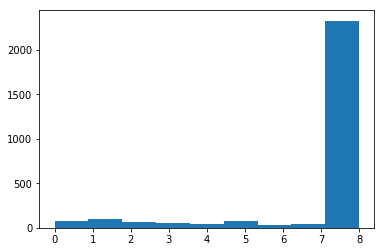

In [121]:
plt.hist(y_train_0102, bins=9)


(array([  81.,  101.,   68.,   51.,   44.,   82.,   27.,   43.,  101.]),
 array([ 0.        ,  0.88888889,  1.77777778,  2.66666667,  3.55555556,
         4.44444444,  5.33333333,  6.22222222,  7.11111111,  8.        ]),
 <a list of 9 Patch objects>)

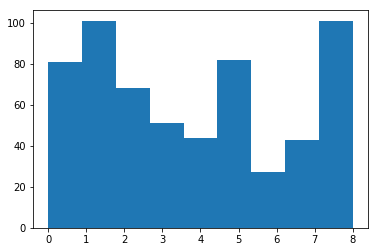

In [147]:
X_train_0102, y_train_0102 = skyds.convert.balanced(
    spX_train_norm[month_keys[0]], spy_train[month_keys[0]], seed=32
)

plt.hist(y_train_0102, bins=9)


再学習  
Visと相関の高い要素を順々に採用する

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


number of feature for max accuracy : 28
number of feature for max f1 : 11


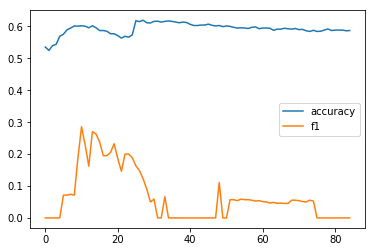

In [148]:
X_test_0102, y_test_0102 = spX_test_norm[month_keys[0]], spy_test[month_keys[0]]
acc, f1 = lo.fwsearch(X_train_0102, y_train_0102, X_test_0102, y_test_0102, filter_method='corr')

plt.plot(acc, label='accuracy')
plt.plot(f1, label='f1')
plt.legend()

print('number of feature for max accuracy :', acc.argmax() + 1)
print('number of feature for max f1 :', f1.argmax() + 1)


F値が最大となる特徴量の組み合わせを採用

In [304]:
selected_fets = pearson_correlation(
    X_train_0102,
    y_train_0102,
    depth=11
)
print(selected_fets)

lo.set_learning_data(
    X_train_0102[selected_fets],
    y_train_0102,
    spX_test_norm[month_keys[0]][selected_fets],
    y_test_0102
)
lo.test_model_performance()


['Rela900', 'Rela850', 'Rela925', 'Rela800', 'Rela950', 'Low cloud cover', 'Rela975', 'Rela1000', 'Medium cloud cover', 'Total cloud cover', 'Rela600']
Test Accuracy: 0.60
Test F value : 0.29


,Predicted +,Predicted -
Actual +,5,16
Actual -,9,1365


時刻を周期関数で正規化

In [305]:
X_train_0102, y_train_0102 = skyds.convert.balanced(
    spX_train_norm[month_keys[0]], spy_train[month_keys[0]], seed=32
)

selected_fets = pearson_correlation(X_train_0102, y_train_0102, depth=11)

X_train_0102 = npd.NWPFrame(X_train_0102)
X_train_0102.sine(column='hour', drop=True, inplace=True)

X_test_0102 = npd.NWPFrame(spX_test_norm[month_keys[0]])
X_test_0102.sine(column='hour', drop=True, inplace=True)

selected_fets += ['sine_hour']

X_train_0102 = X_train_0102[selected_fets]
X_test_0102 = X_test_0102[selected_fets]

lo.set_learning_data(
    X_train_0102,
    y_train_0102,
    X_test_0102,
    y_test_0102
)
lo.test_model_performance()


Test Accuracy: 0.60
Test F value : 0.26


,Predicted +,Predicted -
Actual +,5,16
Actual -,13,1361


あまり変わらない

風向を16段階に変換

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


number of feature for max accuracy : 31
number of feature for max f1 : 22


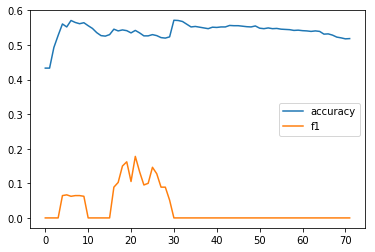

In [32]:
X_train_0102, y_train_0102 = spX_train_norm[month_keys[0]], spy_train[month_keys[0]]
X_test_0102, y_test_0102 = spX_test_norm[month_keys[0]], spy_test[month_keys[0]]

lo.set_learning_data(
    X_train_0102,
    y_train_0102,
    X_test_0102,
    y_test_0102
)
lo.convert_wind_dir()

X_train_0102, y_train_0102 = skyds.convert.balanced(lo.X_train, lo.y_train)

acc, f1 = lo.fwsearch(X_train_0102, y_train_0102, lo.X_test, lo.y_test)

plt.plot(acc, label='accuracy')
plt.plot(f1, label='f1')
plt.legend()

print('number of feature for max accuracy :', acc.argmax() + 1)
print('number of feature for max f1 :', f1.argmax() + 1)

F値の最大値は0.2程度

特徴量をもう少し工夫する  
ある要素を気圧面に対して畳み込んで特徴量に追加  
フィルターはスムージングとエッジ  
まずは湿度について

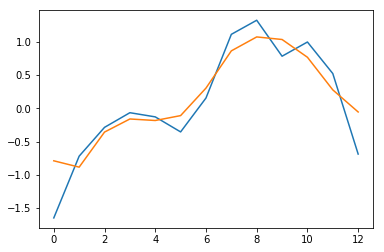

In [22]:
X_train_0102, y_train_0102 = spX_train_norm[month_keys[0]], spy_train[month_keys[0]]
X_test_0102, y_test_0102 = spX_test_norm[month_keys[0]], spy_test[month_keys[0]]

lo.set_learning_data(
    X_train_0102,
    y_train_0102,
    X_test_0102,
    y_test_0102
)

lo.convert_wind_dir()

X_train_0102 = npd.NWPFrame(lo.X_train)
X_test_0102 = npd.NWPFrame(lo.X_test)

X_train_0102.conv(kernel=np.ones((1, 3)) / 3, mode='same', axis=1, pattern='Rela', inplace=True)
X_test_0102.conv(kernel=np.ones((1, 3)) / 3, mode='same', axis=1, pattern='Rela', inplace=True)

rela_keys = X_train_0102.match_keys('Rela')
rela = X_train_0102[rela_keys].loc[0].values

conv_rela_keys = X_train_0102.match_keys('conv')
conv_rela = X_train_0102[conv_rela_keys].loc[0].values

plt.plot(rela)
plt.plot(conv_rela)

X_train_0102, y_train_0102 = skyds.convert.balanced(
    pd.DataFrame(X_train_0102), y_train_0102, seed=32
)


探索

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


number of feature for max accuracy : 51
number of feature for max f1 : 25


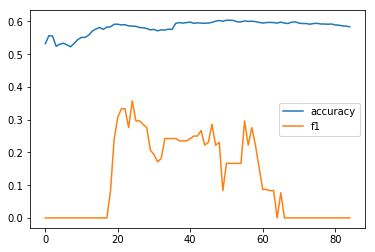

In [25]:
acc, f1 = lo.fwsearch(X_train_0102, y_train_0102, X_test_0102, y_test_0102, filter_method='corr')

plt.plot(acc, label='accuracy')
plt.plot(f1, label='f1')
plt.legend()

print('number of feature for max accuracy :', acc.argmax() + 1)
print('number of feature for max f1 :', f1.argmax() + 1)


In [39]:
selected_fets = pearson_correlation(
    X_train_0102,
    y_train_0102,
    depth=25
)
print(selected_fets)

lo.set_learning_data(
    X_train_0102[selected_fets],
    y_train_0102,
    X_test_0102[selected_fets],
    y_test_0102
)
lo.test_model_performance()

['conv_Rela_6', 'conv_Rela_5', 'Rela900', 'Rela850', 'Rela925', 'conv_Rela_4', 'conv_Rela_7', 'Rela800', 'conv_Rela_3', 'Rela950', 'Low cloud cover', 'conv_Rela_8', 'conv_Rela_2', 'Rela975', 'Rela1000', 'wind direction', 'Medium cloud cover', 'conv_Rela_1', 'Total cloud cover', 'conv_Rela_0', 'conv_Rela_9', 'Rela600', 'Geop1000', 'Geop975', 'Rela700']
Test Accuracy: 0.59
Test F value : 0.36


,Predicted +,Predicted -
Actual +,5,16
Actual -,2,1372


F値は今までで一番良いスコア

気圧面に対する湿度の微分も入れてみる

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


number of feature for max accuracy : 53
number of feature for max f1 : 25


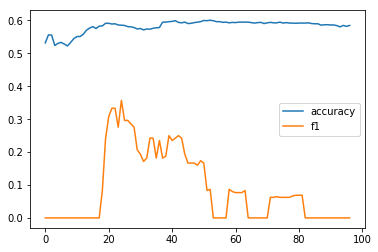

In [12]:
X_train_0102, y_train_0102 = spX_train_norm[month_keys[0]], spy_train[month_keys[0]]
X_test_0102, y_test_0102 = spX_test_norm[month_keys[0]], spy_test[month_keys[0]]

lo.set_learning_data(
    X_train_0102,
    y_train_0102,
    X_test_0102,
    y_test_0102
)

lo.convert_wind_dir()

X_train_0102 = npd.NWPFrame(lo.X_train)
X_test_0102 = npd.NWPFrame(lo.X_test)

X_train_0102.conv(kernel=np.ones((1, 3)) / 3, mode='same', axis=1, pattern='Rela', inplace=True)
X_train_0102.grad(axis=1, pattern='Rela', inplace=True)
X_test_0102.conv(kernel=np.ones((1, 3)) / 3, mode='same', axis=1, pattern='Rela', inplace=True)
X_test_0102.grad(axis=1, pattern='Rela', inplace=True)

X_train_0102, y_train_0102 = skyds.convert.balanced(
    pd.DataFrame(X_train_0102), y_train_0102, seed=32
)

acc, f1 = lo.fwsearch(X_train_0102, y_train_0102, X_test_0102, y_test_0102, filter_method='corr')

plt.plot(acc, label='accuracy')
plt.plot(f1, label='f1')
plt.legend()

print('number of feature for max accuracy :', acc.argmax() + 1)
print('number of feature for max f1 :', f1.argmax() + 1)


In [13]:
selected_fets = pearson_correlation(
    X_train_0102,
    y_train_0102,
    depth=25
)
print(selected_fets)

lo.set_learning_data(
    X_train_0102[selected_fets],
    y_train_0102,
    X_test_0102[selected_fets],
    y_test_0102
)
lo.test_model_performance()

['conv_Rela_6', 'conv_Rela_5', 'Rela900', 'Rela850', 'Rela925', 'conv_Rela_4', 'conv_Rela_7', 'Rela800', 'conv_Rela_3', 'Rela950', 'Low cloud cover', 'conv_Rela_8', 'conv_Rela_2', 'Rela975', 'Rela1000', 'wind direction', 'Medium cloud cover', 'conv_Rela_1', 'Total cloud cover', 'conv_Rela_0', 'conv_Rela_9', 'Rela600', 'Geop1000', 'Geop975', 'Rela700']
Test Accuracy: 0.59
Test F value : 0.36


,Predicted +,Predicted -
Actual +,5,16
Actual -,2,1372


微分はあまり効かない

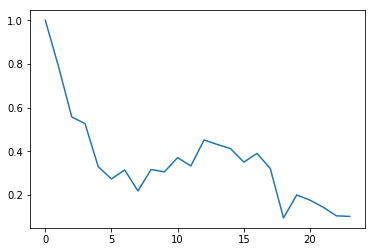

In [66]:
lo.reset_learning_data()

hours = [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 0, 1, 2, 3, 4, 5]
vis = []
collen = 1000000
for h in hours:
    idx = np.where(lo.X_train['hour'].values == h)[0]
    if collen > len(idx): 
        collen = len(idx)
    vis.append(lo.y_train[idx])

vis = np.array([v[:collen] for v in vis])

corr = np.corrcoef(vis)[0]
plt.plot(corr)



当然ながら先の時間になるほど相関は弱くなる  
これを意識して視程の実況値を特徴量に組み込む

In [88]:
fmetar = np.zeros((len(lo.y_train), 9))
fmetar[::24][range(len(fmetar[::24])), lo.y_train.astype(int)[::24]] = 1

alpha = np.log(1 - 1 / fmetar.shape[1])
dfactor = np.exp(-1 / 2 * np.arange(0, 24) + alpha) + 1 / fmetar.shape[1]
plt.plot(dfactor)

for i, d in enumerate(dfactor):
    if i:
        for j, init_v in enumerate(fmetar[::24]):
            if j < len(fmetar[i::24]):
                fmetar[i::24][j] = fmetar[::24][j]

    fmetar[i::24] *= d
    fmetar[i::24][fmetar[i::24] == 0] = (1 - d) / 8

x = np.linspace(0, 9, 9)
y = np.linspace(0, 24, 24)
x, y = np.meshgrid(x, y)

fig = plt.figure(figsize=(4, 4))
ax = Axes3D(fig)
ax.plot_surface(x, y, fmetar[0:24])


<IPython.core.display.Javascript object>

<div id='97ad9596-6c5a-4208-a368-0d94b94b1d61'></div>

<IPython.core.display.Javascript object>

<div id='975ba648-529e-4e36-92b2-a0590ec8634b'></div>

<IPython.core.display.Javascript object>

<div id='a7d20957-9296-498b-969e-1783b88f0b90'></div>

<IPython.core.display.Javascript object>

<div id='871f16d2-3175-4797-951f-9e59bcd1829a'></div>

In [39]:
vis_level_o1 = []
vis_level_u1 = []
for i in range(len(X_train_0102)):
    X_train_0102, y_train_0102 = skyds.convert.balanced(
        spX_train_norm[month_keys[0]],
        spy_train[month_keys[0]]
    )
    # X_test_0102, y_test_0102 = spX_test_norm[month_keys[0]], spy_test[month_keys[0]]

    X_train_0102 = npd.NWPFrame(X_train_0102)
    # X_test_0102 = npd.NWPFrame(X_test_0102)

    rela_keys = X_train_0102.match_keys('Rela')
    rela = X_train_0102[rela_keys].loc[i].values

    X_train_0102.conv(kernel=np.ones((1, 2)) / 2, mode='same', axis=1, pattern='Rela', inplace=True)
    conv_rela_keys = X_train_0102.match_keys('conv')
    conv_rela = X_train_0102[conv_rela_keys].loc[i].values

    if conv.mean() > 1:
        vis_level_o1.append(y_train_0102[i])
    else:
        vis_level_u1.append(y_train_0102[i])

# plt.figure()
# plt.text(0, rela.max() / 2, '%d, %f, %f' % (y_train_0102[i], rela.mean(), conv_rela.mean()), fontsize=16)
# plt.plot(rela)
# plt.plot(conv_rela)


(array([ 19.,  18.,  11.,  14.,  14.,  20.,   3.,   8.,   3.]),
 array([ 0.        ,  0.88888889,  1.77777778,  2.66666667,  3.55555556,
         4.44444444,  5.33333333,  6.22222222,  7.11111111,  8.        ]),
 <a list of 9 Patch objects>)

(array([ 62.,  83.,  57.,  37.,  30.,  62.,  24.,  35.,  98.]),
 array([ 0.        ,  0.88888889,  1.77777778,  2.66666667,  3.55555556,
         4.44444444,  5.33333333,  6.22222222,  7.11111111,  8.        ]),
 <a list of 9 Patch objects>)

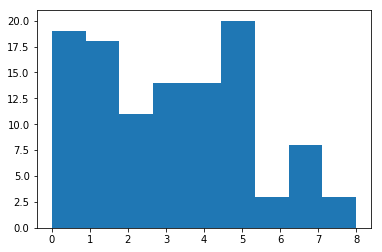

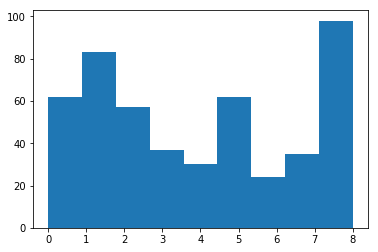

In [35]:
plt.figure()
plt.hist(vis_level_o1, bins=9)

plt.figure()
plt.hist(vis_level_u1, bins=9)